# Mask and Social distancing Detection 

In [ ]:
# This notebook is a fixed updated version of https://www.kaggle.com/code/hitanshugandhi/face-mask-detection

In [1]:
import tensorflow as tf
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


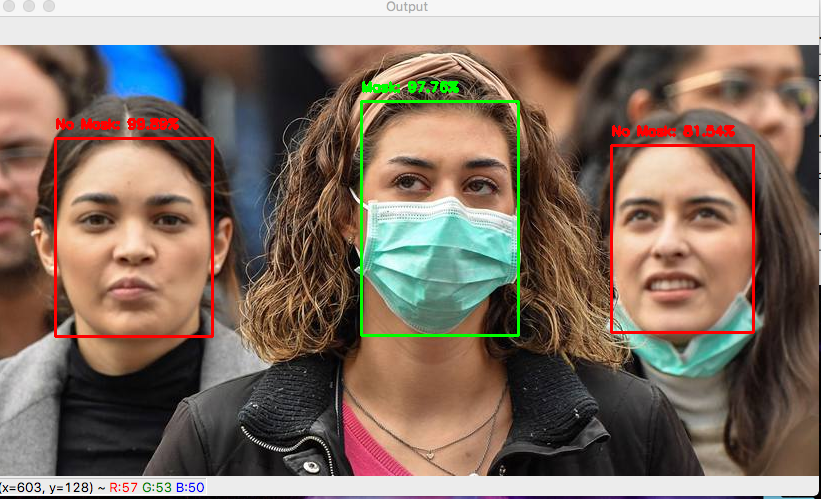

**Social distancing**, also called **“physical distancing,”** means keeping a safe space between yourself and other people who are not from your household.

To practice social or physical distancing, stay at least 6 feet (about 2 arm lengths) from other people who are not from your household in both indoor and outdoor spaces.

**Objective** is to build a Deep Learning model which can identify if the person is wearing a mask or not, also detecting if people vilating social distancing norms.

In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from scipy.spatial import distance
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input/.DS_Store
./input/haarcascades/haarcascade_upperbody.xml
./input/haarcascades/haarcascade_frontalcatface_extended.xml
./input/haarcascades/haarcascade_profileface.xml
./input/haarcascades/haarcascade_frontalcatface.xml
./input/haarcascades/haarcascade_frontalface_alt2.xml
./input/haarcascades/haarcascade_eye.xml
./input/haarcascades/haarcascade_lefteye_2splits.xml
./input/haarcascades/haarcascade_frontalface_alt_tree.xml
./input/haarcascades/haarcascade_licence_plate_rus_16stages.xml
./input/haarcascades/haarcascade_righteye_2splits.xml
./input/haarcascades/haarcascade_frontalface_alt.xml
./input/haarcascades/haarcascade_lowerbody.xml
./input/haarcascades/haarcascade_russian_plate_number.xml
./input/haarcascades/haarcascade_frontalface_default.xml
./input/haarcascades/haarcascade_smile.xml
./input/haarcascades/haarcascade_fullbody.xml
./input/haarcascades/haarcascade_eye_tree_eyeglasses.xml
./input/face-mask-12k-images-dataset/.DS_Store
./input/face-mask-12k-images-dataset/Face

### Using haar cascade to detect faces

Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images. We'll be using a Haar Cascade Model trained to detect faces in order to obtain the bounding box coordinates of faces in an image.

In [3]:
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('./input/haarcascades/haarcascade_frontalface_default.xml')

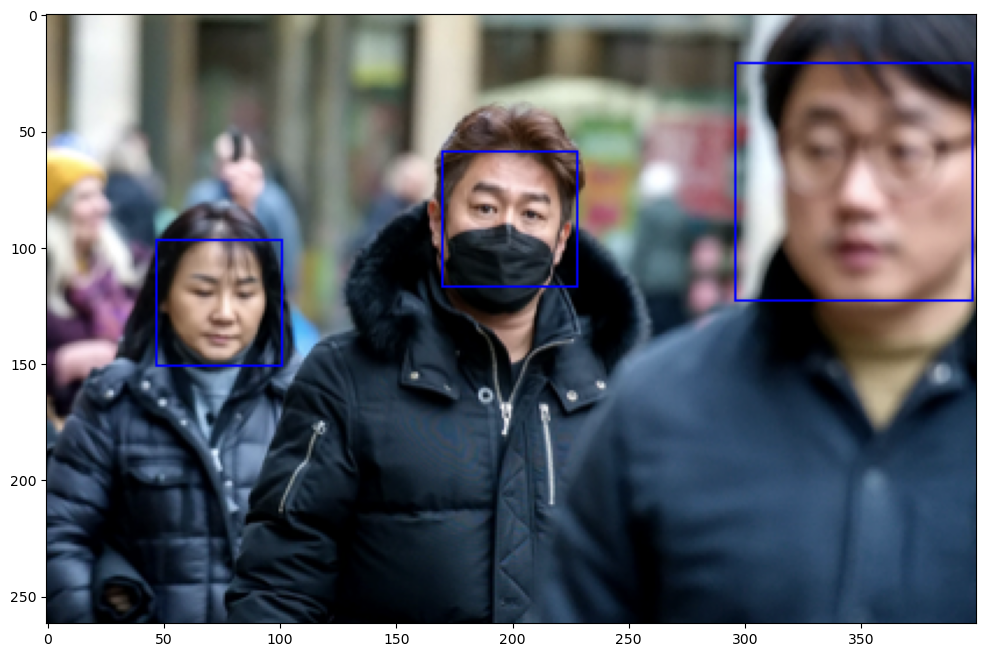

In [4]:
import matplotlib.pyplot as plt
#trying it out on a sample image
img = cv2.imread('./input/face-mask-detection/images/maksssksksss244.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

### Detecting social distancing violations

This can be done by iterating over the coordinates of faces and calculating the distance for each possible pair, if the distance for a particular pair is less than MIN_DISTANCE then the bounding boxes for those faces are colored red. MIN_DISTANCE must be manually initialized in such a way that it corresponds to the minimum allowable distance in real life (ex. 6ft in India).

In [5]:
MIN_DISTANCE = 130

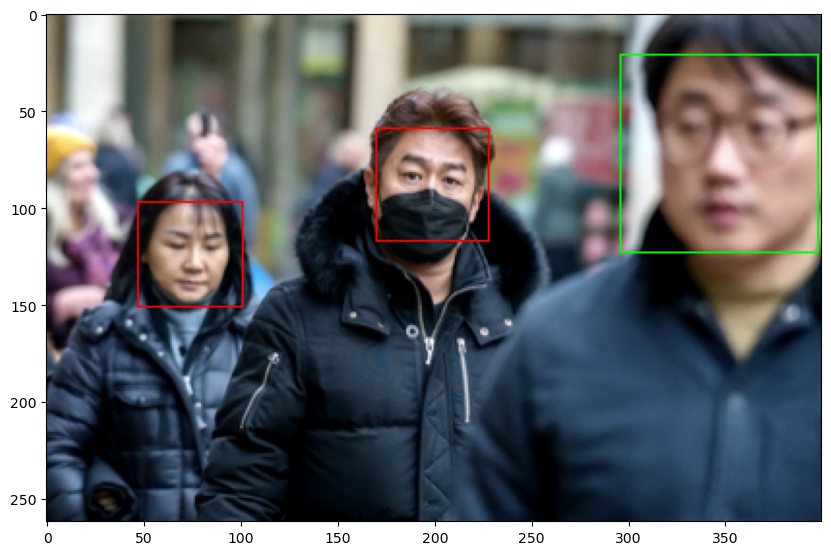

In [6]:
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),1)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

#### Red box shows violation of social distancing.

### Using VGG19 for mask detection


In [7]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.src.legacy.preprocessing.image import ImageDataGenerator

In [8]:
#Load train and test set
train_dir = './input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
test_dir = './input/face-mask-12k-images-dataset/Face Mask Dataset/Test'
val_dir = './input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'

In [9]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Building VGG19 transfer learning model.

In [10]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 4, 4, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │        16,386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,040,770 (76.45 MB)

 Trainable params: 16,386 (64.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [11]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy"])

In [12]:
#history = model.fit_generator(generator=train_generator,
#                              steps_per_epoch=len(train_generator)//32,
#                              epochs=20,validation_data=val_generator,
#                              validation_steps=len(val_generator)//32)

history = model.fit(train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=20,validation_data=val_generator,
                              validation_steps=len(val_generator)//32)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.5983 - loss: 0.8026 - val_accuracy: 0.8575 - val_loss: 0.3411
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.8829 - loss: 0.3147 - val_accuracy: 0.9287 - val_loss: 0.1912
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.9501 - loss: 0.1628 - val_accuracy: 0.9425 - val_loss: 0.1533
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.9631 - loss: 0.1357 - val_accuracy: 0.9513 - val_loss: 0.1322
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.9374 - loss: 0.1333 - val_accuracy: 0.9613 - val_loss: 0.1137
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.9541 - loss: 0.1311 - val_accuracy: 0.9550 - val_loss: 0.1097
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.9718 - loss: 0.0965 - val_accuracy: 0.9688 - val_loss: 0.1051
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.9780 - loss: 0.0742 - val_accuracy: 0.9613 - val_loss: 0.1056
Epoch 9/20
9/9 ━━━━

In [13]:
#model.evaluate_generator(test_generator)
model.predict(test_generator)

25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step 


array([[0.30012518, 0.07193198],
       [0.8140912 , 0.01617911],
       [0.00418722, 0.89773923],
       ...,
       [0.23960106, 0.36035192],
       [0.21534039, 0.22666512],
       [0.00446451, 0.96673137]], dtype=float32)

Our modela achieved 98% accuracy on test data.

### Testing the model on the test data

In [14]:
import cv2
import matplotlib.pyplot as plt

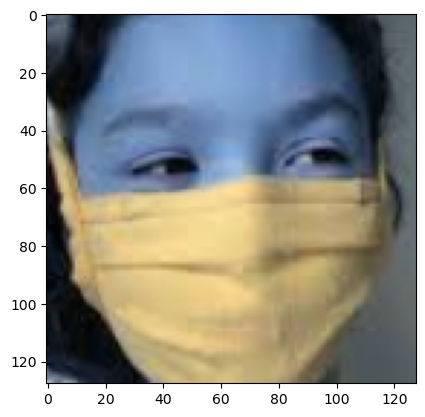

In [15]:
sample_mask_img = cv2.imread('./input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/1565.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0

In [16]:
model.predict(sample_mask_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


array([[0.8969434 , 0.00678845]], dtype=float32)

The model is able to classify if the person is wearing a mask or not.

### Save the model.

In [29]:
from keras.models import save_model, load_model
save_model(model, 'masknet.keras')

### Integrating with haar cascade

We now take crops of the faces detected in the image and use the model trained in the above section to determine whether the individual faces have a mask or not.

In [18]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


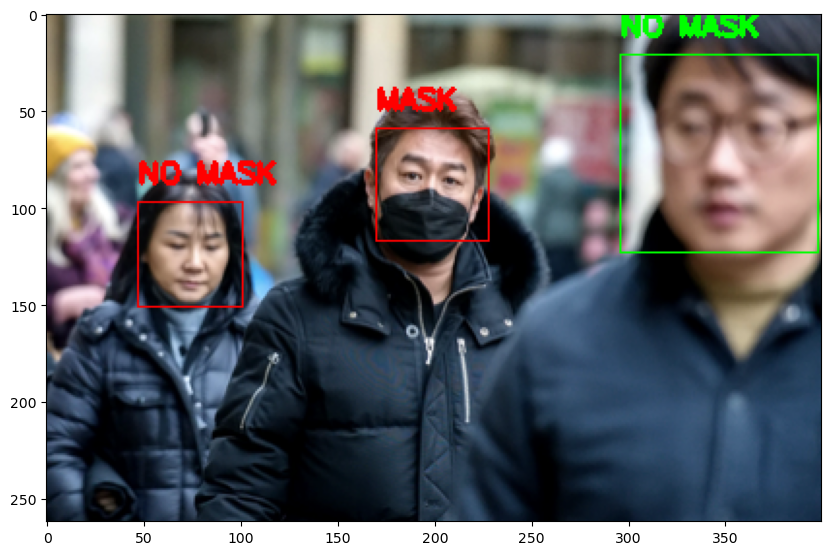

In [19]:
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

#### Red boxes shows violation of social distancing.